# 1 IMPORTS

In [55]:
import random
import pickle
import warnings
import inflection
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import sqlalchemy as db
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn import metrics
from tabulate import tabulate
from IPython.display import Image
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from pycorrcat.pycorrcat import plot_corr, corr_matrix

warnings.filterwarnings('ignore')

## 1.1 Definitions 

In [56]:
# Set Seaborn configurations
sns.set_palette('tab10')
sns.set_style('darkgrid')

# Standard font for plots
def std_font(ax1, title, xlabel, ylabel):
    ax1.set_title(title, loc='left', fontdict={'fontsize': 18}, pad=20)
    ax1.set_xlabel(xlabel, fontdict={'fontsize': 12, 'style': 'italic'})
    ax1.set_ylabel(ylabel, fontdict={'fontsize': 12, 'style': 'italic'})
    return None

def metrics_at_k(X, y, yhat, model_name, perc=0.2):
    k = np.ceil(len(X) * perc)
    # copying data
    df_perf = X.copy()
    df_perf['response'] = y.copy()
    
    # propensity score
    df_perf['score'] = yhat[:,1].tolist()
        
    # sorting values
    df_perf = df_perf.sort_values(by=['score', 'response'], ascending=[False, False])
    df_perf = df_perf.reset_index(drop=True)
    df_perf['ranking'] = df_perf.index + 1
    df_perf['precision_at_k'] = df_perf['response'].cumsum() / df_perf['ranking']
    df_perf['recall_at_k'] = df_perf['response'].cumsum() / df_perf['response'].sum()
    
    precision = df_perf.loc[k, 'precision_at_k']
    recall = df_perf.loc[k, 'recall_at_k']
    return pd.DataFrame({'Model Name': model_name,
                        'Precision':precision,
                        'Recall': recall}, index=[0])

    
def cross_validation(X, y, model_name, model, nfold=10, verbose=False):
    kf = ms.KFold(n_splits=nfold, shuffle=True)
    result = pd.DataFrame ()
#     perf = []
    for k, (train, test) in enumerate(kf.split(X, y)):

        # model training
        model.fit(X.iloc[train,:], y.iloc[train])

        # model prediction
        yhat_model = model.predict_proba(X.iloc[test,:])

        result_at_50 = metrics_at_k(X.iloc[test,:], y.iloc[test], yhat_model, model_name, perc=0.2)
        result = pd.concat([result,result_at_50])
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
    
    return pd.DataFrame({'Model Name': model_name,
                        'Precision':str(round(result['Precision'].mean(),3)) + ' +/- ' + str(round(result['Precision'].std(),5)),
                        'Recall': str(round(result['Recall'].mean(),3)) + ' +/- ' + str(round(result['Recall'].std(),5))},
                        index=[0])

## 1.2 Loading Data

In [57]:
df_raw = pd.read_csv('train.csv')

# Renaming columns
cols_snake = list( map( lambda x: inflection.underscore( x ), df_raw.columns ) )
df_raw.columns = cols_snake

# 2 DATA DESCRIPTION

## 2.1 Data Preview

In [58]:
df_raw.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 2.2 Data Format and Types

In [59]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 2.3 NA Checking and Treatment

In [60]:
df_raw.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 2.4 Discriptive Statistics

### Numerical Attributes

**1.** We observe a extreme high kurtosis value in driving_license and a mean of 1. This is a proof the most customers has a driving license.

**2.** The range of min and max for annual_premium is considerable. We expect some outliers in this feature.

**3.** In response feature, the third quarter is 0.0, that means that most clients are not interested in the vehicle insurance.

In [61]:
num_att = df_raw.select_dtypes(['int64', 'float64'])

In [62]:
# getting skew
skew = pd.DataFrame(num_att.apply(lambda x: x.skew())).round(2).T
skew.rename(index={0: 'skew'}, inplace=True)

# getting kurtosis
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).round(2).T
kurtosis.rename(index={0: 'kurtosis'}, inplace=True)

# numerical features 
describe = num_att.describe().round(2)
m = pd.concat([describe, skew, kurtosis], axis=0)
m.iloc[:,1:]

,age,driving_license,region_code,previously_insured,annual_premium,policy_sales_channel,vintage,response
count,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00,381109.00
mean,38.82,1.00,26.39,0.46,30564.39,112.03,154.35,0.12
std,15.51,0.05,13.23,0.50,17213.16,54.20,83.67,0.33
min,20.00,0.00,0.00,0.00,2630.00,1.00,10.00,0.00
25%,25.00,1.00,15.00,0.00,24405.00,29.00,82.00,0.00
50%,36.00,1.00,28.00,0.00,31669.00,133.00,154.00,0.00
75%,49.00,1.00,35.00,1.00,39400.00,152.00,227.00,0.00
max,85.00,1.00,52.00,1.00,540165.00,163.00,299.00,1.00
skew,0.67,-21.60,-0.12,0.17,1.77,-0.90,0.00,2.30
kurtosis,-0.57,464.35,-0.87,-1.97,34.00,-0.97,-1.20,3.30


### Categorical Attributes

In [63]:
cat_att = df_raw.select_dtypes(['object'])

In [64]:
cat_att.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

# 3 DATAFRAME FILTERING

At first glance, we did not find any discrepant value in rows or useless columns. So we are not filtering this dataset.

## 3.1 Line Filtering

## 3.2 Column Selection

# 4 QUESTIONS & HYPOTHESIS

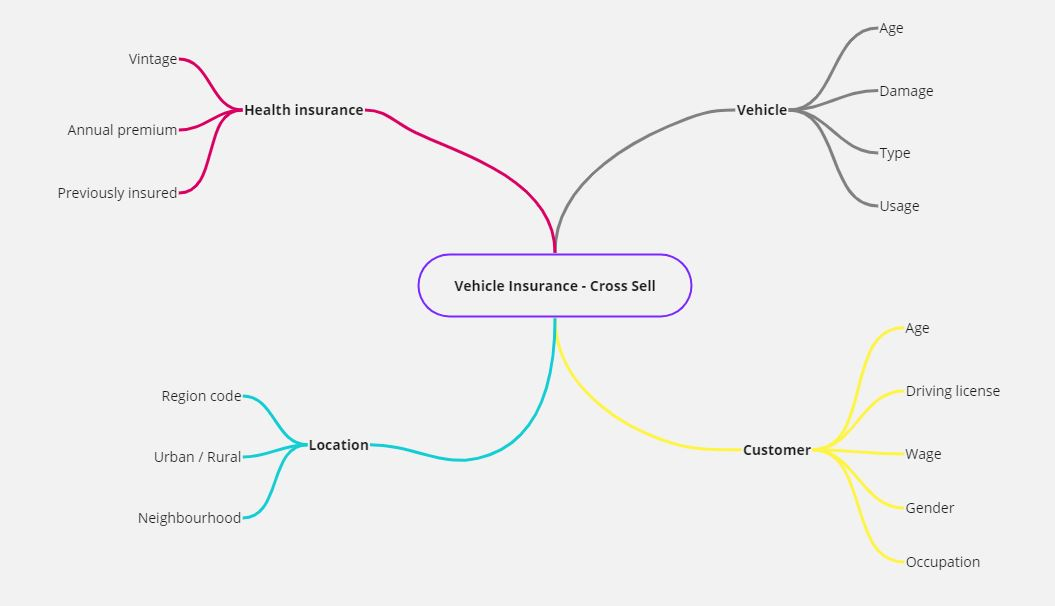

In [65]:
Image( 'mind_map.JPG' )

**1.** Men are more prone to acquire the vehicle insurance than women.

**2.** Older people are more likely to acquire the vehicle insurance

**3.** People who have been previously insured are less likely to acquire the vehicle insurance

**4.** The newer the car, the greater the propensity to acquire vehicle insurance

**5.** People who have already crashed their vehicle are more likely to purchase vehicle insurance

**6.** The older the vehicle, the more expensive is the vehicle insurance

**7.** The contact channel does not influence vehicle insurance adherence

**8.** Older insurers are more likely to purchase vehicle insurance


# 5 FEATURE ENGINEERING

In [14]:
# vehicle_damage
df_raw.loc[:,'vehicle_damage'] = df_raw.loc[:,'vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)


# 6 EXPLORATORY DATA ANALYSIS

## 6.1 Univariate Analysis

### 6.1.1 Response Variable

Based on the plot below, we can see that our response variable is highly unbalanced. This is an important issue when building our model.

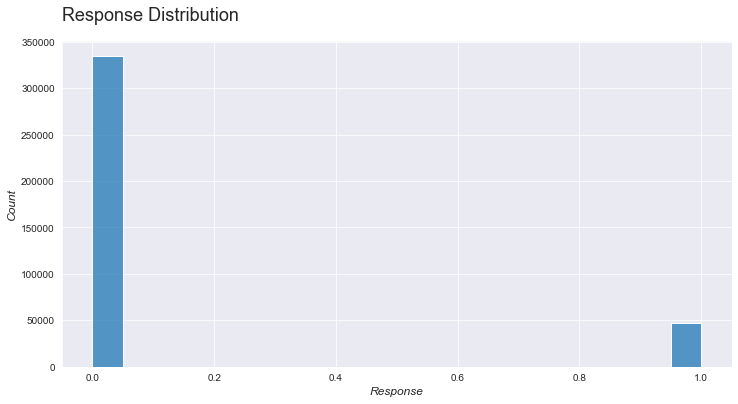

In [15]:
plt.figure(figsize=(12, 6))
ax1 = sns.histplot(data=df_raw, x='response')
std_font(ax1, 'Response Distribution', 'Response', 'Count')

### 6.1.2 Numerical Variable

In the plots below we can se that Annual Premium is very close to a normal distribution. This will be important to section 7.

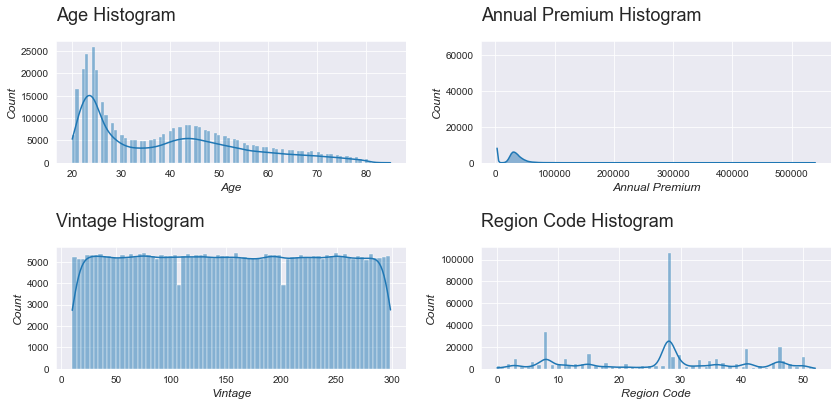

In [16]:
plt.figure(figsize=(12, 6), tight_layout={'pad': 2.0})

plt.subplot(2, 2, 1)
ax1 = sns.histplot(data=num_att, x="age", kde=True)
std_font(ax1, 'Age Histogram',
         'Age', 'Count')
plt.subplot(2, 2, 2)
ax2 = sns.histplot(data=num_att, x="annual_premium", kde=True)
std_font(ax2, 'Annual Premium Histogram', 'Annual Premium', 'Count')
plt.subplot(2, 2, 3)
ax3 = sns.histplot(data=num_att, x="vintage", kde=True)
std_font(ax3, 'Vintage Histogram',
         'Vintage', 'Count')
plt.subplot(2, 2, 4)
ax4 = sns.histplot(data=num_att, x="region_code", kde=True)
std_font(ax4, 'Region Code Histogram', 'Region Code', 'Count')


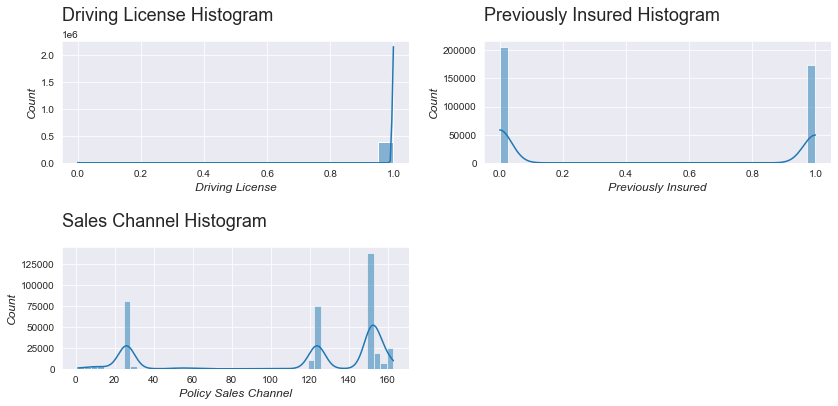

In [17]:
plt.figure(figsize=(12, 6), tight_layout={'pad': 2.0})

plt.subplot(2, 2, 1)
ax5 = sns.histplot(data=num_att, x="driving_license", kde=True)
std_font(ax5, 'Driving License Histogram', 'Driving License', 'Count')
plt.subplot(2, 2, 2)
ax6 = sns.histplot(data=num_att, x="previously_insured", kde=True)
std_font(ax6, 'Previously Insured Histogram', 'Previously Insured', 'Count')
plt.subplot(2, 2, 3)
ax6 = sns.histplot(data=num_att, x="policy_sales_channel", kde=True)
std_font(ax6, 'Sales Channel Histogram', 'Policy Sales Channel', 'Count')


### 6.1.3 Categorical Variable

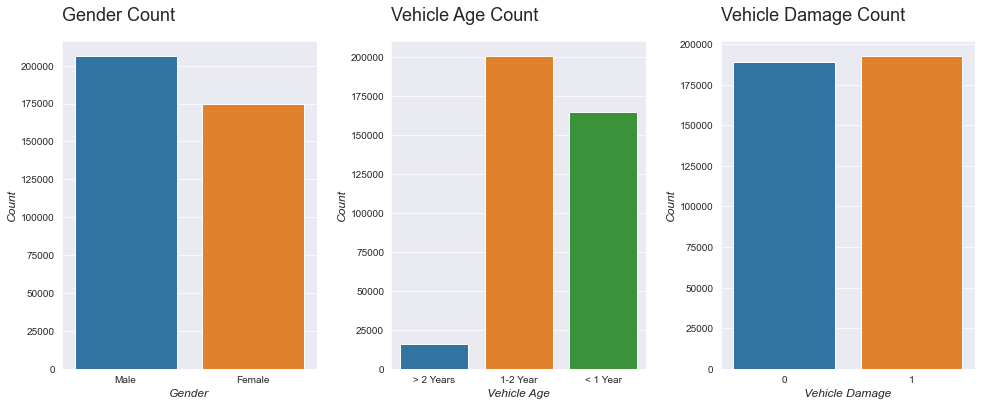

In [18]:
plt.figure(figsize=(14, 6), tight_layout={'pad': 2.0})
plt.subplot(1, 3, 1)
ax1 = sns.countplot(x="gender", data=df_raw)
                  
std_font(ax1, 'Gender Count', 'Gender', 'Count')

plt.subplot(1, 3, 2)
ax2 = sns.countplot(x="vehicle_age", data=df_raw)
                  
std_font(ax2, 'Vehicle Age Count', 'Vehicle Age', 'Count')

plt.subplot(1, 3, 3)
ax2 = sns.countplot(x="vehicle_damage", data=df_raw)
                  
std_font(ax2, 'Vehicle Damage Count', 'Vehicle Damage', 'Count')

## 6.2 Bivariate Analysis

### Men are more prone to acquire the vehicle insurance than women.

**TRUE** - 61% of interested customers are men while 39% are women.

In [19]:
# aggregating features
gender_response = df_raw[['gender', 'response']].query('response == 1').groupby('gender').count().reset_index()

total = gender_response.iloc[1,1] + gender_response.iloc[0,1]
male = round((gender_response.iloc[1,1] / total) * 100, 2)
female = round((gender_response.iloc[0,1] / total) * 100, 2)

display (gender_response)
print(f'{male}% of the interested customers is male')
print(f'{female}% of the interested customers is female')

,gender,response
0,Female,18185
1,Male,28525


61.07% of the interested customers is male
38.93% of the interested customers is female


### Older people are more likely to acquire the vehicle insurance
**FALSE** - Older and newer people are less likely to acquire the vehicle insurance. People aging 40-50 are the more interested in the insurance.

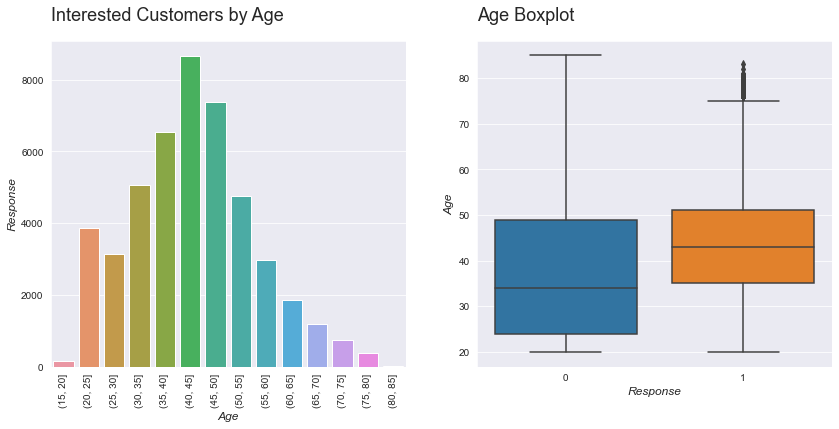

In [20]:
# aggregating features
age_response = df_raw[['age', 'response']].groupby( 'age' ).sum().reset_index()
bins = list(np.arange(15, 90, 5))

age_response['age_binned'] = pd.cut(
    age_response['age'], bins=bins)

age_response_bin = age_response[['age_binned', 'response']].groupby(
    'age_binned').sum().reset_index()

# plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
ax1 = sns.barplot( x='age_binned', y='response', data=age_response_bin )
std_font(ax1, 'Interested Customers by Age', 'Age', 'Response')
plt.xticks( rotation=90 );

plt.subplot(1, 2, 2)
ax2 = sns.boxplot( x='response', y='age', data=df_raw )
std_font(ax2, 'Age Boxplot', 'Response', 'Age')

### People who have been previously insured are less likely to acquire the vehicle insurance
**TRUE** - Almost 100% of customers who would acquire the vehicle insurance is not previously insured.

In [21]:
insured_response = df_raw[['previously_insured', 'response']].groupby('previously_insured').sum().reset_index()
display(insured_response)


,previously_insured,response
0,0,46552
1,1,158


### The newer the car, the greater the propensity to acquire vehicle insurance
**FALSE** - People with older and newer cars are less likely to acquire the vehicle insurance. People with car with 1-2 years are more interested in the insurance.

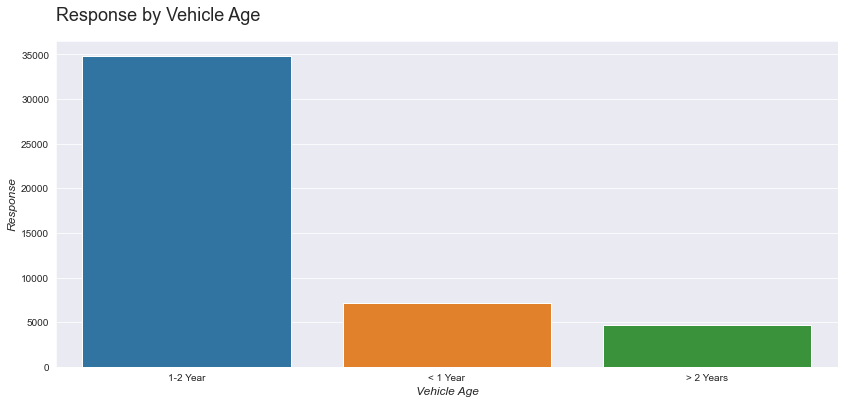

In [22]:
# aggregating features
vehicle_age_response = df_raw[['vehicle_age', 'response']].groupby('vehicle_age').sum().reset_index()

# plotting
plt.figure(figsize=(14, 6))
ax1 = sns.barplot(data=vehicle_age_response, x='vehicle_age', y='response')
std_font(ax1, 'Response by Vehicle Age', 'Vehicle Age', 'Response')

### People who have already crashed their vehicle are more likely to purchase vehicle insurance
**TRUE** - More than 95% of interested customers already have damaged their car.

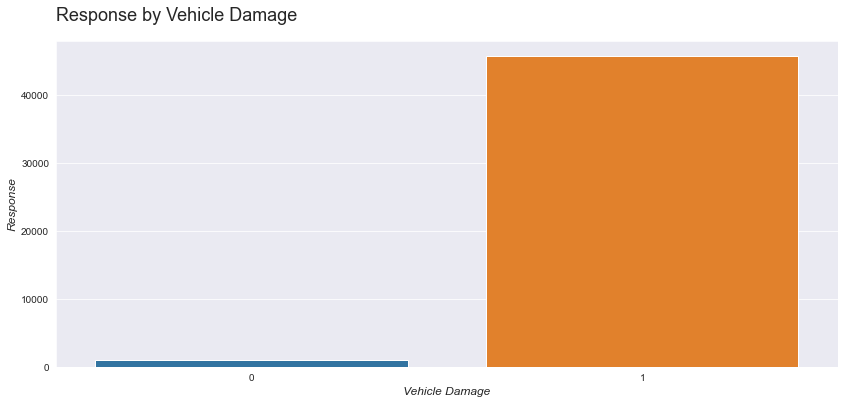

In [23]:
# aggregating features
vehicle_damage_response = df_raw[['vehicle_damage', 'response']].groupby('vehicle_damage').sum().reset_index()

# plotting
plt.figure(figsize=(14, 6))
ax1 = sns.barplot(data=vehicle_damage_response, x='vehicle_damage', y='response')
std_font(ax1, 'Response by Vehicle Damage', 'Vehicle Damage', 'Response')

### On average, the older the vehicle, the more expensive is the vehicle insurance
**FALSE** - This hypothesis is only true for cars with more than 2 years. Before that, the average value is the same.

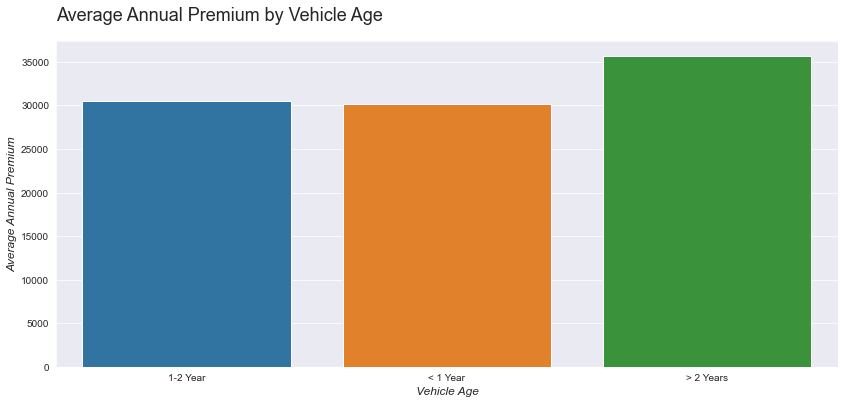

In [24]:
# aggregating features
vehicle_age_annual_premium = df_raw[['vehicle_age', 'annual_premium']].groupby('vehicle_age').mean().reset_index()

# plotting
plt.figure(figsize=(14, 6))
ax1 = sns.barplot(data=vehicle_age_annual_premium, x='vehicle_age', y='annual_premium')
std_font(ax1, 'Average Annual Premium by Vehicle Age', 'Vehicle Age', 'Average Annual Premium')

### The contact channel does not influence vehicle insurance adherence
**FALSE** - There are plenty of ineffective contact channels. While others concentrate most of the interested customers.

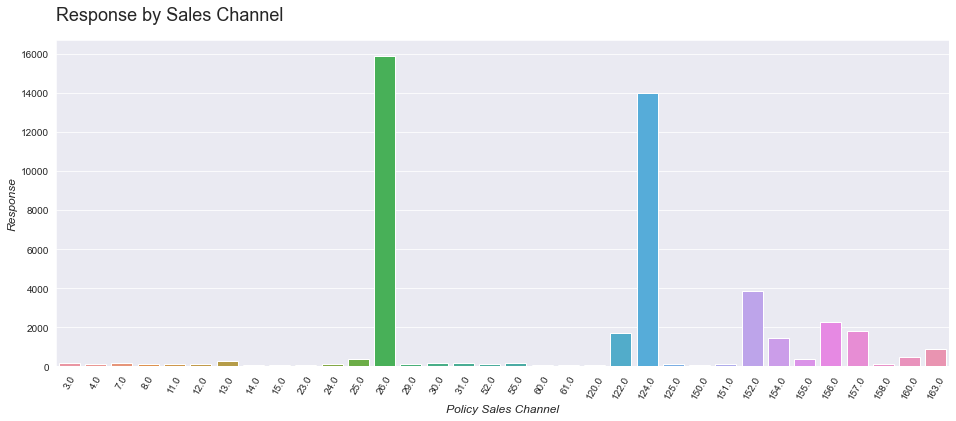

In [25]:
# aggregating features
policy_sales_channel_response = df_raw[['policy_sales_channel', 'response']].groupby(
    'policy_sales_channel').sum().reset_index().query('response > 50')

# plotting
plt.figure(figsize=(16, 6))
ax1 = sns.barplot(data=policy_sales_channel_response,
                  x='policy_sales_channel', y='response')
plt.xticks(rotation=60)
std_font(ax1, 'Response by Sales Channel', 'Policy Sales Channel', 'Response')

### Older insurers are more likely to purchase vehicle insurance
**FALSE** - The interested customers are equally distributed by different vintage values

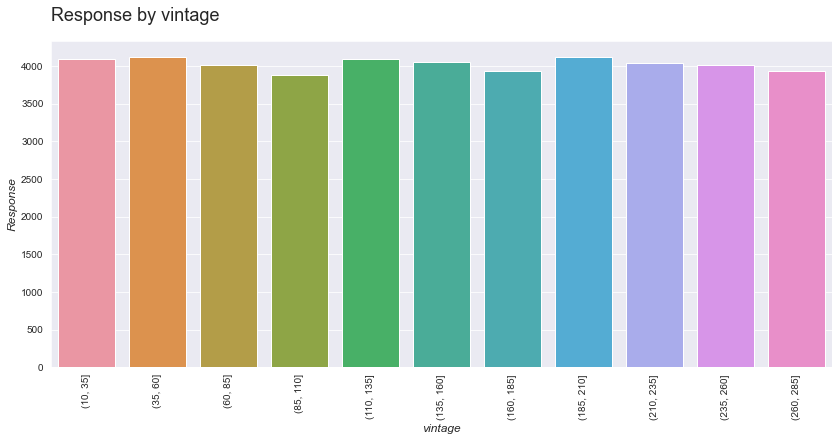

In [26]:
# aggregating features
vintage_response = df_raw[['vintage', 'response']].groupby( 'vintage' ).sum().reset_index()
bins = list(np.arange(10, 300, 25))

vintage_response['vintage_binned'] = pd.cut(
    vintage_response['vintage'], bins=bins)

vintage_response_bin = vintage_response[['vintage_binned', 'response']].groupby(
    'vintage_binned').sum().reset_index()

# plots
plt.figure(figsize=(14, 6))
ax2 = sns.barplot( x='vintage_binned', y='response', data=vintage_response_bin )
std_font(ax2, 'Response by vintage', 'vintage', 'Response')
plt.xticks( rotation=90 );

### 6.2.10 Hypothesis overview

In [27]:
tab =[['Hypothesis', 'Conclusion', 'Relevance', 'Discover'],
      ['H1', 'True', 'Medium', '61% of interested customers are men while 39% are women.'],  
      ['H2', 'False', 'Medium', 'People aging 40-50 are the more interested in the insurance.'],  
      ['H3', 'True', 'High', 'Almost 100% of interested customers are not previously insured.'],
      ['H4', 'False', 'Medium', 'People with car with 1-2 years are more interested in the insurance.'],
      ['H5', 'True', 'Low', 'More than 95% of interested customers already have damaged their car.'],
      ['H6', 'False', 'Low', 'Until 2 years the price is the same, but after this limit, the price grows'],
      ['H7', 'False', 'High', 'Most channels are ineffective. While few concentrate most of the interested customers.'],
      ['H8', 'False', 'Low', 'The interested customers are equally distributed by different vintage values']
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Relevance    Discover
------------  ------------  -----------  --------------------------------------------------------------------------------------
H1            True          Medium       61% of interested customers are men while 39% are women.
H2            False         Medium       People aging 40-50 are the more interested in the insurance.
H3            True          High         Almost 100% of interested customers are not previously insured.
H4            False         Medium       People with car with 1-2 years are more interested in the insurance.
H5            True          Low          More than 95% of interested customers already have damaged their car.
H6            False         Low          Until 2 years the price is the same, but after this limit, the price grows
H7            False         High         Most channels are ineffective. While few concentrate most of the interested customers.
H8            False         Low          The interes

## 6.3 Multivariate Analysis


### 6.3.1 Numerical Attributes

From the Heatmap below, we can see that our features has low to medium correlation with our target variable. Thus, we will not expect a high performance model. The best thing to do is to build the best model we can, with the features we have. Then, in others CRISP-DM/DS cycles, we try to enhance this model adding other features.

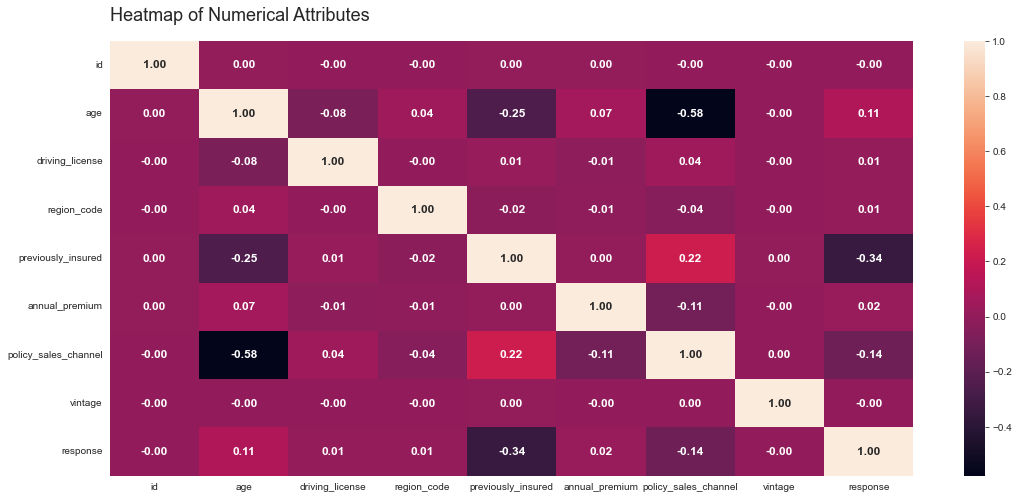

In [28]:
correlation = num_att.corr( method='pearson' )
plt.figure( figsize=(18, 8) )
ax1 = sns.heatmap(data=correlation, annot=True, fmt='.2f', annot_kws={'fontsize':12, 'fontweight':'bold'})
std_font(ax1, 'Heatmap of Numerical Attributes', '', '')

### 6.3.2 Categorical Attributes

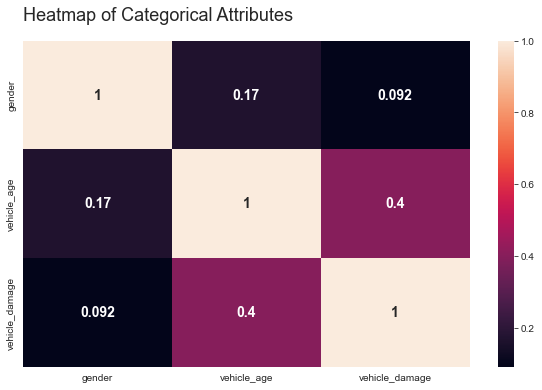

In [29]:
correlation_matrix = corr_matrix(cat_att,columns=['gender','vehicle_age','vehicle_damage'])
plt.figure( figsize=(10, 6) )
ax1 = sns.heatmap(data=correlation_matrix, annot=True, annot_kws={'fontsize':14, 'fontweight':'bold'})
std_font(ax1, 'Heatmap of Categorical Attributes', '', '')

# 7 DATA PREPARATION

## 7.2 Normalization

In [30]:
# annual premium  -> Normalization
ss = pp.StandardScaler()

df_raw.loc[:, 'annual_premium'] = ss.fit_transform(df_raw[['annual_premium']].values)
pickle.dump(ss, open('parameter/annual_premium_scaler.pkl', 'wb'))

## 7.3 Rescaling

In [31]:
# age -> minmax scaler
mms_age = pp.MinMaxScaler()
df_raw.loc[:, 'age'] = mms_age.fit_transform(df_raw[['age']].values)
pickle.dump(mms_age, open('parameter/age_scaler.pkl', 'wb'))

# vintage -> minmax scaler
mms_vintage = pp.MinMaxScaler()
df_raw.loc[:, 'vintage'] = mms_vintage.fit_transform(df_raw[['vintage']].values)
pickle.dump(mms_vintage, open('parameter/vintage_scaler.pkl', 'wb'))

## 7.4 Transformation

### 7.4.1 Encoding

In [32]:
# region_code -> target encoding
target_encoding_region_code = df_raw.groupby('region_code')['response'].mean()
df_raw.loc[:, 'region_code'] = df_raw['region_code'].map(target_encoding_region_code)
pickle.dump(target_encoding_region_code, open('parameter/region_code_scaler.pkl', 'wb'))

# gender -> target encoding
target_encoding_gender = df_raw.groupby('gender')['response'].mean()
df_raw.loc[:, 'gender'] = df_raw['gender'].map(target_encoding_gender)
pickle.dump(target_encoding_gender, open('parameter/gender_scaler.pkl', 'wb'))

# vehicle_age -> one hot encoding
df_raw = pd.get_dummies(
    df_raw, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel -> frequency encoding
freq_police_channel = df_raw.groupby('policy_sales_channel').size() / len(df_raw)
df_raw.loc[:, 'policy_sales_channel'] = df_raw['policy_sales_channel'].map(freq_police_channel)
pickle.dump(freq_police_channel, open('parameter/policy_sales_channel_scaler.pkl', 'wb'))

# 8 FEATURE SELECTION

## 8.1 Split dataframe into training and validation dataset

In [33]:
X = df_raw.drop(columns=['response'])
y = df_raw['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=11)
df_train = pd.concat([x_train, y_train], axis=1)

## 8.2 Extra Tree Classifier

We will use this algorithm to get the importance of each feature. It works similarly to the random forest. The difference is that after randomly choosing the features to be used in a particular tree, the extra tree classifier also does a random split in the data. 

In [34]:
# model
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=1)

# applying model
x_train_n = df_train.drop(['id','response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=1, random_state=0)

Feature Ranking: 
                 feature  importance
0                vintage    0.272805
0         annual_premium    0.245248
0                    age    0.166085
0            region_code    0.104666
0         vehicle_damage    0.069887
0   policy_sales_channel    0.060213
0     previously_insured    0.053976
0   vehicle_age_< 1 Year    0.013353
0   vehicle_age_1-2 Year    0.006443
0                 gender    0.004732
0  vehicle_age_> 2 Years    0.002096
0        driving_license    0.000497


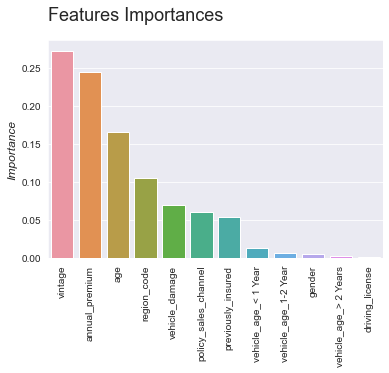

In [35]:
# the importance of each feature according to the model
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]


# Feature Ranking
print('Feature Ranking: ')
ranking = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    ranking = pd.concat([ranking,aux], axis=0)
    
print(ranking.sort_values('importance', ascending=False))

# plotting the feature importance
ax1 = sns.barplot(data=ranking.sort_values('importance', ascending=False), x='feature', y='importance' )
std_font(ax1, 'Features Importances', '', 'Importance')
plt.xticks( rotation=90 );

## 8.3 Selected Features

In [36]:
selected_cols = list(ranking.sort_values('importance', ascending=False)['feature'][:7])

x_train = x_train[selected_cols]
x_valid = x_val[selected_cols]

# 9 MACHINE LEARNING MODELLING

At first sight, we imagine that our problem is a classification problem. But, we are not only interested in identifying the customers who would buy the vehicle insurance. Actually, we want to sort these people according to its probability to acquire the insurance. In other words: we need to build a sorted list starting with the costumers with higher probability to buy the insurance.

With that being said, we will categorize our problem as a learning to rank problem. For that matter, we will use the following metrics: Cumulative Gains Curve, Lift Curve, Precision and Recall.

**Cumulative Gains Curve**: It shows the percentage of targets reached when considering a certain percentage of the population with the highest probability to be target according to the model.

**Lift Curve**: Measures how much better is our model compared to a random model.

**Precision**: Percentage of people that our model ranked as high probability and they really were interested in the insurance.

**Recall**: Percentage of the entire interested customers that our top-k model selected as high probability.

## 9.1 KNN

,Model Name,Precision,Recall
0,KNN,0.383,0.62


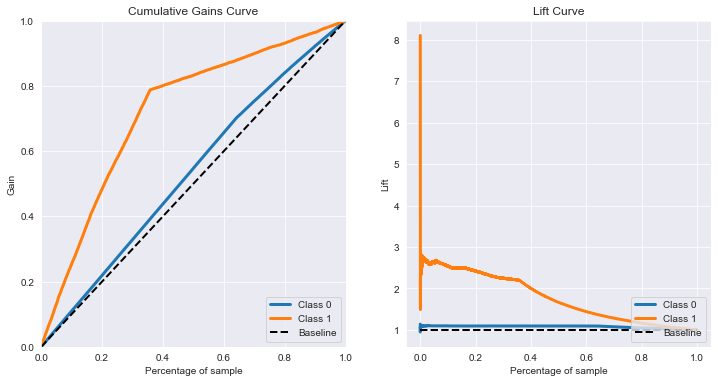

In [37]:
# model
knn_model = nh.KNeighborsClassifier(n_neighbors=5)

# model training
knn_model.fit(x_train, y_train)

# model prediction
yhat_knn = knn_model.predict_proba(x_valid)

fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax=axs[0])

# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_knn, ax=axs[1])

# metrics
metrics_at_20_knn = round(metrics_at_k(x_val, y_val, yhat_knn, 'KNN', perc=0.2),3)
display(metrics_at_20_knn)

## 9.2 Logistic Regression

,Model Name,Precision,Recall
0,Logistic Regression,0.295,0.477


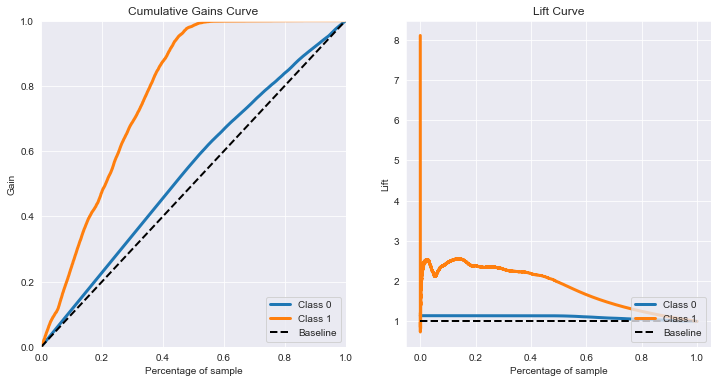

In [38]:
# model
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_valid)

fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax=axs[0])

# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr, ax=axs[1])

# metrics
metrics_at_20_lr = round(metrics_at_k(x_val, y_val, yhat_lr, 'Logistic Regression', perc=0.2),3)
display(metrics_at_20_lr)

## 9.3 XGBoost

,Model Name,Precision,Recall
0,XGBoost,0.334,0.542


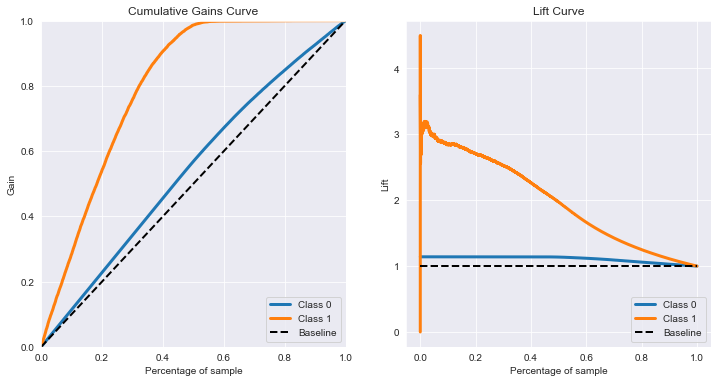

In [39]:
# model
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=10, subsample=0.7, eval_metric='logloss')

# model training
xgb_model.fit(x_train, y_train, verbose=False)

# model prediction
yhat_xgb = xgb_model.predict_proba(x_valid)

fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb, ax=axs[0])

# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_xgb, ax=axs[1])

# metrics
metrics_at_20_xgb = round(metrics_at_k(x_val, y_val, yhat_xgb, 'XGBoost', perc=0.2),3)
display(metrics_at_20_xgb)

## 9.4 Random Forest 

,Model Name,Precision,Recall
0,Random Forest,0.327,0.529


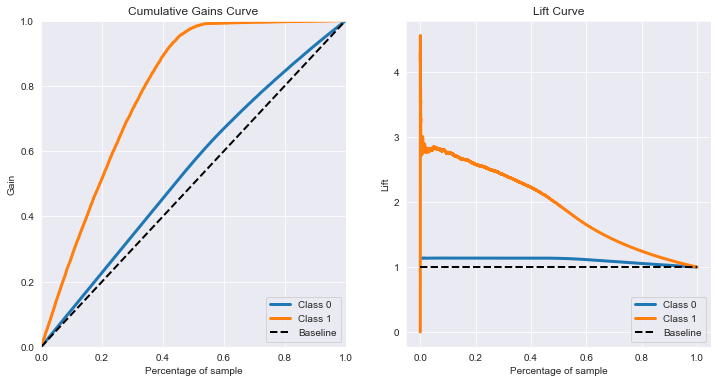

In [40]:
# model
rfc_model = en.RandomForestClassifier()

# model training
rfc_model.fit(x_train, y_train)

# model prediction
yhat_rfc = rfc_model.predict_proba(x_valid)

fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rfc, ax=axs[0])

# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_rfc, ax=axs[1])

# metrics
metrics_at_20_rfc = round(metrics_at_k(x_val, y_val, yhat_rfc, 'Random Forest', perc=0.2),3)
display(metrics_at_20_rfc)

## 9.5 Models Comparison

In [41]:
modelling_result = pd.concat( [metrics_at_20_knn, metrics_at_20_lr, metrics_at_20_rfc, metrics_at_20_xgb])
modelling_result.sort_values( 'Precision', ascending=False )

,Model Name,Precision,Recall
0,KNN,0.383,0.620
0,XGBoost,0.334,0.542
0,Random Forest,0.327,0.529
0,Logistic Regression,0.295,0.477


From the previous metrics, we can see that the performance regarding the cumulative gains curve in 40% of the sample was almost ecqual (targeting 90% of the interested customers). Furthermore, we see that the KNN metrics are the bests so far. We will validate our models with the cross-validation method.

# 10 CROSS-VALIDATION

In [42]:
# Filtering the selected cols for the  model
X = X[selected_cols]

## 10.1 CV- Logistic Regression

In [43]:
cv_lr = cross_validation(X, y, 'Logistic_Regression', lr_model, nfold=10, verbose=False)
cv_lr

,Model Name,Precision,Recall
0,Logistic_Regression,0.29 +/- 0.00395,0.474 +/- 0.00574


## 10.2 CV- KNN

In [44]:
cv_knn = cross_validation(X, y, 'KNN', knn_model, nfold=10, verbose=False)
cv_knn

,Model Name,Precision,Recall
0,KNN,0.37 +/- 0.01045,0.604 +/- 0.01756


## 10.3 CV- XGBoost

In [45]:
cv_xgb = cross_validation(X, y, 'XGBoost', xgb_model, nfold=10, verbose=False)
cv_xgb

,Model Name,Precision,Recall
0,XGBoost,0.334 +/- 0.00695,0.545 +/- 0.00555


## 10.4 CV- Random Forest

In [46]:
cv_rfc = cross_validation(X, y, 'Random Forest', rfc_model, nfold=10, verbose=False)
cv_rfc

,Model Name,Precision,Recall
0,Random Forest,0.326 +/- 0.00326,0.533 +/- 0.0052


## 10.5 CV- Models Comparison

In [47]:
cv_result = pd.concat( [cv_knn, cv_lr, cv_rfc, cv_xgb])
cv_result.sort_values( 'Precision', ascending=False )

,Model Name,Precision,Recall
0,KNN,0.37 +/- 0.01045,0.604 +/- 0.01756
0,XGBoost,0.334 +/- 0.00695,0.545 +/- 0.00555
0,Random Forest,0.326 +/- 0.00326,0.533 +/- 0.0052
0,Logistic_Regression,0.29 +/- 0.00395,0.474 +/- 0.00574


After the cross-validation method we got more realistic results. This is very important because we want a model with high generalization ability. After this step, we will continue with the KNN model.

# 11 HYPERPARAMETER FINE TUNNING

Now we will implement a random search algorithm in order to find better results for our model.

## 11.1 Random Search

In [48]:
# selecting the possible parameters to be taken
param = {
   'n_neighbors': list(range(5,16)),
   'p': [1,2],
       }

MAX_EVAL = 5 # Quantidades de iterações do tuning

# ===================================================================================
# COMMENTED BECAUSE IT TAKES A WHILE TO RUN AND ITS OUTPUT WAS SAVED IN A .CSV FILE
# ===================================================================================
# * To minimize the execution time, it is good to run it in a GPU or TPU based environment.

# Choosed model: XGBoost

# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
# #choose values for parameters randomly
#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() } # .items retorna os itens (key-values) de um dicionario
#     print(hp)
#     # model
#     knn_2 = nh.KNeighborsClassifier(n_neighbors=hp['n_neighbors'], p=hp['p'], n_jobs=4)                           

#     # performance
#     result = cross_validation( X, y, 'XGBoost Regressor', knn_2, nfold=10, verbose=True )
#     final_result = pd.concat( [final_result, result] )
# final_result

# =======================
# Best p: 1
# Best n_neighbors: 7
# =======================

## 11.2 Final Model

,Model Name,Precision,Recall
0,KNN (5%),0.346,0.14


,Model Name,Precision,Recall
0,KNN (10%),0.416,0.337


,Model Name,Precision,Recall
0,KNN (20%),0.384,0.622


,Model Name,Precision,Recall
0,KNN (40%),0.268,0.869


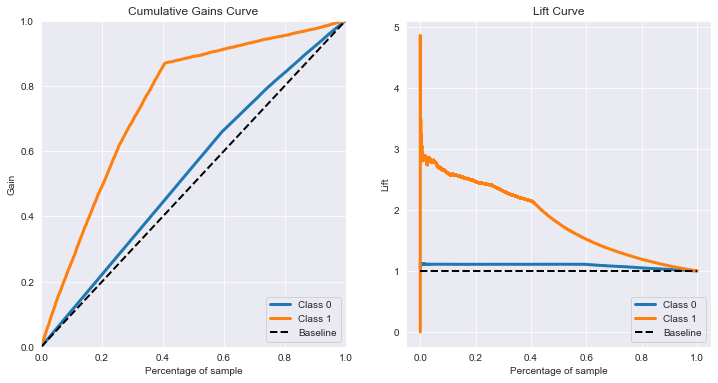

In [49]:
# model
knn_model = nh.KNeighborsClassifier(n_neighbors=7, p=1)

# model training
knn_model.fit(x_train, y_train)
pickle.dump(knn_model, open('model/knn_model.pkl', 'wb'))

# model prediction
yhat_knn = knn_model.predict_proba(x_valid)

fig, axs = plt.subplots(ncols=2, figsize=(12,6))
# Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax=axs[0])

# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_knn, ax=axs[1])

# metrics at 5%
metrics_at_10_knn = round(metrics_at_k(x_val, y_val, yhat_knn, 'KNN (5%)', perc=0.05),3)
display(metrics_at_10_knn)

# metrics at 10%
metrics_at_10_knn = round(metrics_at_k(x_val, y_val, yhat_knn, 'KNN (10%)', perc=0.1),3)
display(metrics_at_10_knn)

# metrics at 20%
metrics_at_20_knn = round(metrics_at_k(x_val, y_val, yhat_knn, 'KNN (20%)', perc=0.2),3)
display(metrics_at_20_knn)

# metrics at 40%
metrics_at_40_knn = round(metrics_at_k(x_val, y_val, yhat_knn, 'KNN (40%)', perc=0.4),3)
display(metrics_at_40_knn)

# 12 BUSINESS PERFORMANCE

To build our business performance analysis, we will use the average cost per call* of \\$2.20 and the average cost of a vehicle insurance** of \\$1,652 per year.

\* [F. Curtis Barry & Company](https://www.fcbco.com/articles-and-whitepapers/articles/bid/129578/managing-your-cost-per-call#:~:text=The%20direct%20labor%20cost%20ranges,%242.70%20to%20%245.60%20per%20call.)

\*\* [Policy Genius](https://www.policygenius.com/auto-insurance/learn/how-much-is-car-insurance/)

## 12.1 Scenario: Cost to Reach 87% of Interested Customers

To reach the intended amount of customers, the random method will have to make 331,470 calls, while our model will have to make only 152,400 calls. This is a reduction of **54%** in number of calls.

To make these calls, with the random methor the company needs to spend \\$729,234.00, while our model will only spend \\$335,280.00. It is a **\\$394,000.00** economy in the budget.

## 12.2 Scenario: Making only 20,000 calls

In this scenario the company has limited resources to prospect these clients, and the capacity is to make only twenty thousands calls.

With 20k calls the random method will only make deal with 2451 customers, while our model will make 6920 deals with the customers. Based on the average price of vehicle insurance, our model will increase the company income by **\\$7,382,788.00** in the next year.

# 13 NEXT STEPS

- Try another combination of features to build the model
- Try other standatization / normalization of data to build the model
- In a business sphere, try to gather more information to our dataset, in order to improve its performance
- Improve the Google Sheets interface with other functionalities, to enhance the user experience